In [1]:
import pyham
from Bio import SeqIO
import os
import matplotlib.pyplot as plt
import networkx as nx

print(pyham.__version__, "   ", nx.__version__)

1.1.7     2.4


In [2]:
def locus_to_id(file):
    
    """
    This function extracts loci from a fasta file and store the information as keys in a dictionary 
    and the related protein ID as value.

    Args:
        file (:obj:`str`): path to the file of interest.

    Returns:
        a dictionary mapping the locus (:obj:`str`) with the protein ID (:obj:`str`).
    """
    
    locus_to_id = {}
    for seq_record in SeqIO.parse(file, 'fasta'):
        locus_to_id[seq_record.description.split('locus: ')[-1]] = seq_record.description
        
    return locus_to_id


def get_locus(directory):
    
    """
    This function goes through each file of a folder and build a dictionary containing loci 
    as keys and the related protein ID as values. For each entry in the dictionary, the function 
    updates the corresponding :obj:`pyham.abstractgene.Gene` by adding its locus.

    Args:
        directory (:obj:`str`): directory of interest.

    Returns:
        xxx
    """

    path = directory
    for file in os.listdir(path):
        ##print('File:', file)
        path_to_file = path + '/' + file
        locus_dictionary = locus_to_id(path_to_file)
 
        for (loci, gene_id) in locus_dictionary.items():
            gene = ham_analysis_no_name.get_genes_by_external_id(gene_id)
            
            # each gene should only map to 1 other gene, so should always be length 1...
            assert len(gene) == 1, 'gene_id maps to multiple entries'
            gene[0].locus = loci
            #for element in gene:
            #    element.locus = loci
                
        ham_analysis_no_name.get_extant_genome_by_name('.'.join(file.split('.')[:-1])).locus_assignment = True
        

def get_gene_by_locus(genome, locus):
    
    """
    Get a :obj:`pyham.abstractgene.Gene` that match the query locus. 

    Args:
        genome (:obj:`pyham.genome.Genome`): extant genome of interest.
        locus (:obj:`int`): locus.

    Returns:
        :obj:`pyham.abstractgene.Gene`.
    """
    
    for gene in genome.genes:
        if int(gene.locus) == locus:
            return gene 
    
    return None

In [3]:
def assign_neighbors(genome):
    
    """
    This function assigns neighbors to each :obj:`pyham.abstractgene.Gene` or :obj:`pyham.abstractgene.HOG`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        
        for extant_gene in genome.genes:
            extant_gene.neighbors = (get_gene_by_locus(genome, int(extant_gene.locus)-1), 
                                     get_gene_by_locus(genome, int(extant_gene.locus)+1))            
                        
    if isinstance(genome, pyham.AncestralGenome):
    
        for ancestral_gene in genome.genes:  
            
            # test here, see if does the same thing, children should only be direct descendants?
            #children = [child for child in ancestral_gene.children]
            children = ancestral_gene.children
            
            ######################################################################################
            # Dictionary containing genome names as keys (i.e. SE004) and a list of children as value #
            ######################################################################################
            
            genome_dict = {}  
            
            for child in children:
                if child.genome.name in genome_dict:
                    genome_dict[child.genome.name].append(child) # if already in dictionary, add it (duplicate)
                else:
                    genome_dict[child.genome.name] = [child] # otherwise add the child
            
            ############################################
            # Children are replaced by their neighbors #      
            ############################################
            
            for genome, gene_collection in genome_dict.items(): #stoca 
                for i in range(len(gene_collection)):
                    gene_collection[i] = list(gene_collection[i].neighbors)
            
            ################################################################################
            # Dictionary containing genomes as keys (i.e. SE004) and a list of parent HOGs #
            ################################################################################
            
            parent_dict = {} # gets a list of all potential neighboring hogs to the ancestral_gene
            for genome, neighbors_collection in genome_dict.items(): #stoca 
                for neighbors_pair in neighbors_collection:
                    for neighbor in neighbors_pair: # don't really need the for loop bc only ever 2 neighbors
                        if genome in parent_dict:   ## KJG - I don't understand this if/else - if we already put the focal genome in the parent dictionary, we do the same thing as if we didn't?
                            if neighbor == None:
                                parent_dict[genome].add(None)
                            else:
                                if neighbor.parent != ancestral_gene: #if theres' a duplication this might be true
                                    parent_dict[genome].add(neighbor.parent) #add the neighbors parents - the neighboring hogs
                        else:
                            if neighbor == None:
                                parent_dict[genome] = {None}    ## ah, this makes focal genome 'none' while above does 'add(None)' in addition to current genome?
                            else:
                                if neighbor.parent != ancestral_gene: # fill the parent dict by looking to see 
                                    parent_dict[genome] = {neighbor.parent}  ## again, no 'add', just make

            l = []  # List of sets
            for genome, parent in parent_dict.items():  
                l.append(parent)  # parent is a set
                ancestral_gene.list_parents = l            # List of potential neighbors in case of conflict
                
            final_neighbors = list(l[0].intersection(*l))  # Intersection of the sets
            
            if len(final_neighbors) == 2:
                ancestral_gene.neighbors = tuple(final_neighbors)
                print("fin", ancestral_gene.neighbors)
            
            elif len(final_neighbors) == 1:
                none_counter = 0
                potential_neighbor = None
                
                for collection in l:
                    if len(collection) == 2:
                        for element in collection:
                            if element == final_neighbors[0]:
                                continue
                            elif element == None:
                                none_counter += 1
                            else:
                                potential_neighbor = element
                
                    else:
                        break
                
                if none_counter == 1:  # To deal with missing orthology
                    final_neighbors.append(potential_neighbor)
                
                if len(final_neighbors) == 1:
                    final_neighbors.append(None)
                    ancestral_gene.neighbors = tuple(final_neighbors)
                else:  
                    ancestral_gene.neighbors = tuple(final_neighbors)
            
            elif len(final_neighbors) == 0 or len(final_neighbors) > 2:
                final_neighbors = [None, None]
                ancestral_gene.neighbors = tuple(final_neighbors)


def get_synteny_blocks(genome):
    
    """
    This function aims to reconstruct synteny blocks using neighbors of :obj:`pyham.abstractgene.AbstractGene`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        list of lists containing :obj:`pyham.abstractgene.Gene` or :obj:`pyham.abstractgene.HOG` 
        in a specific order.
    """

    syn_blocks = []
    seen = []
    gene_collection = genome.genes
    tmp = []
        
    for abstract_gene in gene_collection: # go through all the genes (extant or ancestral) for the genome
        
        if abstract_gene in seen: # if the gene is already there, skip out of the loop to the next gene
            continue
                
        block1 = []
        block2 = []
        
        current1 = abstract_gene
        current2 = abstract_gene  # Used for the block2
        
        block1.append(current1)  # [X] where X is the first abstract gene # add the current gene to block 1
        seen.append(current1) # append the current gene to seen
        
        ######################
        # First end (block1) #
        ######################
        
        next_gene = current1.neighbors[0] # find the neighbors of the current gene
        
        while next_gene != None: # if there is a next gene
            
            if next_gene in seen:
                next_gene = None  
                continue
            
            previous = current1 # then put the current gene as previous
            current1 = next_gene # and put the next gene as current
            
            if previous in current1.neighbors:   # if the previous gene is a neighbor of the new current gene
                block1.append(current1) # append the new current gene to block 1
                seen.append(current1)   # append the new current gene to seen
                # this step should always be true and the else statement is a check that breaks if not true
            
            else:                                  
                break
                print("previous gene is not a neighbor of the current gene")
                
            if previous == current1.neighbors[0]: # if the previous gene is the first neighbor of the current gene
                next_gene = current1.neighbors[1] # then the next gene equals the 2nd neighbor of the current gene
            
            else:
                next_gene = current1.neighbors[0] # otherwise the next gene is the first neighbor of the current gene
            # then iterate the while loop

        #######################
        # Second end (block2) #
        #######################
        
        next_gene = current2.neighbors[1] # current2 is the same original abstract gene from above
                                          # take its 2nd neighbor and make it the next gene
            
        while next_gene != None:    # if there is a next gene
            
            if next_gene in seen:   # if it's already seen, next = none and iterate the while loop
                next_gene = None
                continue
            
            previous = current2    # make the current gene become the previous gene
            current2 = next_gene   # make the next gene become the current gene
            
            if previous in current2.neighbors:   # if the previous gene is a neighbor of the new next current gene
                block2.append(current2)  # append the new current gene to block 2
                seen.append(current2)    # append the new current gene to seen
            
            else:                                  
                break
                print("previous gene is not a neighbor of the current2 gene")
                
            if previous == current2.neighbors[0]: # if the previous gene is the first neighbor of the current gene
                next_gene = current2.neighbors[1] # then the next gene equals the 2nd neighbor of the current gene
            
            else:
                next_gene = current2.neighbors[0] # otherwise the next gene is the first neighbor of the current gene
            # then iterate the while loop
            
        syn_blocks.append(block1[::-1] + block2)
        
    print(syn_blocks)
    genome.synteny = syn_blocks


def assign_block_to_genes(genome):
    
    """
    The function links each :obj:`pyham.abstractgene.AbstractGene` to the synteny block it belongs to. 
    It creates a dictionary containing the genome of :obj:`pyham.abstractgene` as key and the synteny 
    block as value.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    
    """
    
    for block in genome.synteny:
    
        for abstract_gene in block:
            genomes_to_block = {}  # Dictionary
            genomes_to_block[genome.name] = block  
            abstract_gene.blocks = genomes_to_block
            

def get_unique_children(genome, children):  
    
    """
    Due to tandem duplication, some :obj:`pyham.abstractgene.HOG` can have more than two children.
    The function refines the list of children by removing duplicates.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        children (:obj:`list` of :obj:`pyham.abstractgene.AbstractGene`): a list of direct descendants AbstractGene.
    
    Returns:
        list of :obj:`pyham.abstractgene.AbstractGene` without duplicates.
    """
    
    unique_genome = []
    unique_children = []
    
    if len(children) == 2:  # Two children comming from two different genomes
        
        if children[0].genome != children[1].genome:
            return children
        
        else:  # Two children comming from the same genome (i.e. duplication)
            unique_children.append(None)
            return unique_children
    
    else:  # In case of duplications, only one child per specie is taken into account
        
        for child in children:  
            
            if child.genome in unique_genome:
                continue

            else:
                
                for neighbor in child.neighbors:
                    
                    if neighbor == None:
                        continue

                    elif neighbor.parent:
                        
                        if neighbor.parent in child.parent.blocks[genome.name]:  # To make sure that, for both unique children, we go in the same direction. 
                            continue
                        
                        unique_genome.append(child.genome)
                        unique_children.append(child)

                    else:  # If the child has no parent HOG
                        unique_genome.append(child.genome)
                        unique_children.append(child)
        
        if len(unique_children) == 0:
            unique_children.append(None)
            return unique_children  
        
        else:
            return unique_children 
        

def check_unique_children_from_unit_block(genome, children, genes_seen):
    
    """
    This function aims to be used after refining the :obj:`list` genes_seen. It uses the :obj:`list` 
    genes_seen to check whether the :obj:`list` current_children returned by the function get_unique_children 
    are correctly selected. Indeed, the function get_unique_children encounters a limitation with single HOG.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        children (:obj:`list` of :obj:`pyham.abstractgene.AbstractGene`): a list of direct descendants AbstractGene.
        genes_seen (:obj:`list`): a list of genes already assessed.
        
    Returns:
        list of :obj:`pyham.abstractgene.AbstractGene`.
    """
    
    unique_genome = []
    unique_children = []
    
    if len(children) == 2:  # Two children comming from two different genomes
        
        if children[0].genome != children[1].genome:
            return children
        
        else:  # Two children comming from the same genome (i.e. duplication)
            unique_children.append(None)
            return unique_children
        
    else:
        
        for child in children:  
            
            if child.genome in unique_genome:
                continue
            
            for neighbor in child.neighbors:
                
                if neighbor == None:
                    continue

                if neighbor.parent in child.parent.blocks[genome.name] or neighbor in genes_seen:  # To make sure that for both unique children we go in the same direction 
                    continue
                
                unique_genome.append(child.genome)
                unique_children.append(child)
                
        if len(unique_children) == 0:
            unique_children.append(None)
            return unique_children  # Return a list without duplicates
        
        else:
            return unique_children  

        
class Link:
    
    """
    Link is a class representing linking regions. Linking regions are unresolved regions with a weak synteny 
    signal that links two synteny blocks together. A Link is defined by its collection of poorly resolved genes.
    
    Attributes:
        | linking_region: dictionary of :obj:`pyham.abstractgene.AbstractGene`
    """
    
    def __init__(self):
        self.linking_region = {}
        
    def get_linking_region(self, genome, block, common_block, starting_children):
        
        """
        Create a linking region filled with :obj:`pyham.abstractgene.AbstractGene`.
        
        Args:
            genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
            block (:obj:`list`): the synteny block from which the assessement starts.
            common_block (:obj:`list`): the synteny block to be linked with the initial block.
            starting_children (:obj:`list`): list of children coming from the last :obj:`pyham.abstractgene.AbstractGene` of the initial block.
        
        Returns:
            return linking_region: dictionary of :obj:`pyham.abstractgene.AbstractGene`.
        """
        
        initial_children = starting_children
        seen = []

        for child in initial_children:  # Creation of the dictionary's entries ({species1: [], species2: []})

            if child.genome.name in self.linking_region:
                continue

            else:
                self.linking_region[child.genome.name] = [] 

        next_children = []

        for child in initial_children:
            current_child = child
            growing_link = True

            while growing_link:
                
                for neighbor in current_child.neighbors:
                    
                    if neighbor == None:
                        continue
                        
                    if neighbor != current_child.next_neighbor:
                        continue

                    if neighbor.parent:

                        if neighbor.parent.blocks[genome.name] != common_block:
                            
                            if neighbor.parent not in self.linking_region[neighbor.genome.name]:
                                self.linking_region[neighbor.genome.name].append(neighbor.parent)
                                current_child = neighbor
                                seen.append(neighbor)

                            else:
                                current_child = neighbor
                                seen.append(neighbor)

                        else:
                            growing_link = False

                    else:
                        self.linking_region[neighbor.genome.name].append(neighbor)  # The child is added to the linking region anyway.
                        current_child = neighbor
                        seen.append(neighbor)

    def __repr__(self):
        return '<{}>'.format(self.__class__.__name__)
    
    
def refine_genes_seen(genome, genes_seen, current_children):
    
    """
    Regarding the secondary reconstruction, when the growing process continue by starting from a single 
    :obj:`pyham.abstractgene.HOG`, both neighbors of one of its children can be within the 
    :obj:`list` genes_seen. The function will remove all children that come after the children of interest
    within the :obj:`list` genes_seen.
    
    Ars:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        genes_seen (:obj:`list`): a list of genes already assessed.
        current_children (:obj:`list`): list of children to begin the investigation with at the next iteration.
        
    Returns:
        return the refined :obj:`list` genes_seen.
    """
    
    if len(current_children) == 2:
        tmp = genes_seen[:]  # Make an independent copy of the initial list

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == current_children[0]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == current_children[0].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:]

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == current_children[1]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == current_children[1].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:] 

    return genes_seen


def adjust_genes_seen(genome, genes_seen, starting_children):
    
    """
    Same principle as for the function refine_genes_seen but used when the growing process continue by
    sarting from an element at the extremity of a synteny block. Neighbors from one of its children can
    be present within the :obj:`list` genes_seen. The function will remove all children that come after 
    the children of interest within the :obj:`list` genes_seen.
    
    Ars:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        genes_seen (:obj:`list`): a list of genes already assessed.
        starting_children (:obj:`list`): list of children to begin the investigation with at the next iteration.
        
    Returns:
        return the refined :obj:`list` genes_seen.
    """
    
    if len(starting_children) == 2:
        tmp = genes_seen[:]  # Make an independent copy of the initial list

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == starting_children[0]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == starting_children[0].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:]

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == starting_children[1]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == starting_children[1].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:] 

    return genes_seen


def joining_blocks(window, genome):
    
    """
    The function performs the secondary reconstruction. Synteny blocks from the primary reconstruction
    are linked together using linking regions.
    
    Ars:
        window (:obj:`int`): a window of assessment
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        
    Returns:
        xxx
    """
    
    for hog in genome.genes:  #### To be used with the function "add_remaining_blocks"
        hog.processed = False
    
    new_blocks = []
    block_record = []  # To keep track of the block already assessed. Useful to link several blocks in a row.
    
    for block in genome.synteny:
            
        if block in block_record or len(block) == 1:  
            continue
        
        block2 = block  # Used to reconstruct the other side
        
        counter = 0
        children = [child for child in block[-1].children]
        current_children = get_unique_children(genome, children)  # Remove duplicates from children
        starting_children = current_children  # To keep track of the initial children considered (used to build a linking region)
        
        if len(current_children) == 1 or len(current_children) > 2:  # If missing information (==1) or other special case (>2), the block is no longer taken into account
            continue
        
        block_record.append(block)   
        
        blocks_seen = [set() for child in current_children]  # To save already assessed blocks and perform the intersection
        genes_seen = []  # To keep track of already assessed genes
        intersect = None
        extended_block = []
        next_children = [None, None]
        genes_seen.append(current_children[0])  
        genes_seen.append(current_children[1])  
        
        while counter < window:
            none_type_as_neighbor = 0
            block_found = False
            reaching_already_assessed = False  
            
            if None in current_children:
                break
            
            # Without the following block, when a common block is reached from one extremity, the next iteration 
            # starts from the opposite one. However, children originating from that extreme element are not
            # added within the list of genes seen.
            if current_children[0] and current_children[1] not in genes_seen:
                genes_seen.append(current_children[0])
                genes_seen.append(current_children[1])
            
            for i in range(len(current_children)):
                
                for neighbor in current_children[i].neighbors:
                    
                    if neighbor == None:
                        none_type_as_neighbor += 1
                        continue
                        
                    if neighbor.parent:  # Check whether the neighbor is a singleton (i.e. does it have a parent or not?)
                        
                        if neighbor.parent in block or neighbor in genes_seen:  # Avoid to take into account elements from the initial block or those already assessed
                            continue

                        else:
                            blocks_seen[i].add(tuple(neighbor.parent.blocks[genome.name]))
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region 
                            break
                    
                    else:
                        
                        if neighbor in genes_seen:
                            continue

                        else:
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region
                
            if none_type_as_neighbor > 0:  # If children have only one neighbor
                break

            counter += 1
            current_children = next_children[:]
            intersect = list(blocks_seen[0].intersection(*blocks_seen))  # Intersection
            
            if len(intersect) == 1:  # ex. intersect = [('a', 'c')]

                    if list(intersect[0]) in block_record:
                        reaching_already_assessed = True
                        break
                        
                    block_found = True  
                    counter = 0  # Reset the counter to pursue the assessement with further blocks
                    common_block = list(intersect[0])  # Extraction of the last common block. 
                    block_record.append(common_block)

                    link = Link()  # Class for linking regions
                    link.get_linking_region(genome, block, common_block, starting_children)  # Creation of the linking region
                    
                    if not extended_block:  # If the list if empty (i.e. for a first block of a serie)
                        extended_block.append(block)  # The initial block
                        extended_block.append(link)  # The linking region
                        extended_block.append(common_block)  # The common block

                    else:  # For all the block but the first one, "block" corresponds to the previous common block
                        extended_block.append(link)
                        extended_block.append(common_block)

                    block = common_block  # The new block becomes the last common block found within the while loop

                    if len(block) > 1:
                        
                        #################################################################################################################################################
                        # If we reach a common block toward its first element (i.e. element 0), the next iteration should start from its last element (i.e. element -1) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block[0].children)) == 2:
                            
                            if get_unique_children(genome, block[0].children)[0] and get_unique_children(genome, block[0].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block[-1].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)  

                        else:
                            current_children = get_unique_children(genome, block[0].children)
                            break

                        #################################################################################################################################################
                        # If we reach a common block toward its last element (i.e. element -1), the next iteration should start from its first element (i.e. element 0) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block[-1].children)) == 2:
                            
                            if get_unique_children(genome, block[-1].children)[0] and get_unique_children(genome, block[-1].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block[0].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)

                        else:
                            current_children = get_unique_children(genome, block[-1].children)
                            break
                    
                    ################################################################################################################
                    # When we reach a common unit block, the next iteration should start from the same unique HOG (i.e. element 0) #
                    ################################################################################################################

                    elif len(block) == 1:  # If the block has only one HOG...
                        current_children = get_unique_children(genome, block[0].children)                         
                        
                        if len(current_children) == 2:
                            genes_seen = refine_genes_seen(genome, genes_seen, current_children)
                            current_children = check_unique_children_from_unit_block(genome, block[0].children, genes_seen)

                        starting_children = current_children
                        
                    blocks_seen = [set() for child in current_children]  # The variable is restarted for the next iteration

            if reaching_already_assessed:  
                break
                
            if len(current_children) == 2:
                if current_children[0].genome != current_children[1].genome:
                    continue
                
                break  # To exit the while loop
                
            else:  
                break  # To exit the while loop
        
        tmp = [[], []]
        if extended_block:
            for item in extended_block:
                if isinstance(item, Link):
                    tmp[1].append(item)

                else:
                    for element in item:
                        tmp[1].append(element)
        
        else:
            for element in block:
                tmp[1].append(element)  # If a new initial block reach directly an already assessed block (i.e. common block), the initial block is stored
                
###############################################################################################################

        counter = 0
        children = [child for child in block2[0].children]
        current_children = get_unique_children(genome, children)  # Remove duplicates from children
        starting_children = current_children
        
        if len(current_children) == 1 or len(current_children) > 2:  # If missing information (==1) or other special case (>2), the block is no longer taken into account
            new_blocks.append(tmp[1])
            continue
        
        blocks_seen = [set() for child in current_children]  # To save already assessed blocks and perform the intersection
        genes_seen = []  # To keep track of already assessed genes (used for gene without parent to make to we go in one direction)
        intersect = None
        extended_block = []
        next_children = [None, None]
        genes_seen.append(current_children[0])  
        genes_seen.append(current_children[1])  
        
        while counter < window:
            none_type_as_neighbor = 0
            block_found = False
            reaching_already_assessed = False  
            
            if None in current_children:
                break
            
            # Without the following block, when a common block is reached from one extremity, the next iteration 
            # starts from the opposite one. However, children originating from the that extreme element are not
            # added within the list of genes seen.
            if current_children[0] and current_children[1] not in genes_seen:
                genes_seen.append(current_children[0])
                genes_seen.append(current_children[1])
            
            for i in range(len(current_children)):
                
                for neighbor in current_children[i].neighbors:
                    
                    if neighbor == None:
                        none_type_as_neighbor += 1
                        continue
                        
                    if neighbor.parent:  # Check whether the neighbor is a singleton (i.e. does it have a parent or not?)
                        
                        if neighbor.parent in block2 or neighbor in genes_seen:  # Avoid to take into account elements from the initial block or those already assessed
                            continue

                        else:
                            blocks_seen[i].add(tuple(neighbor.parent.blocks[genome.name]))
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region 
                            break  

                    else:
                        
                        if neighbor in genes_seen:
                            continue

                        else:
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region
                
            if none_type_as_neighbor > 0:  # If children have only one neighbor
                break

            counter += 1
            current_children = next_children[:]
            intersect = list(blocks_seen[0].intersection(*blocks_seen))  # Intersection
            
            if len(intersect) == 1:  # ex. intersect = [('a', 'c')]

                    if list(intersect[0]) in block_record:
                        reaching_already_assessed = True
                        break
                        
                    block_found = True  
                    counter = 0  # Reset the counter to pursue the assessement with further blocks
                    common_block = list(intersect[0])  # Extraction of the last common block. 
                    block_record.append(common_block)

                    link = Link()  # Class for linking regions
                    link.get_linking_region(genome, block2, common_block, starting_children)  # Creation of the linking region
                    
                    extended_block.append(link)  # The linking region
                    extended_block.append(common_block)  # The common block

                    block2 = common_block  # The new block becomes the last common block found within the while loop

                    if len(block2) > 1:
                        
                        #################################################################################################################################################
                        # If we reach a common block toward its first element (i.e. element 0), the next iteration should start from its last element (i.e. element -1) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block2[0].children)) == 2:
                            
                            if get_unique_children(genome, block2[0].children)[0] and get_unique_children(genome, block2[0].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block2[-1].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)

                        else:
                            current_children = get_unique_children(genome, block2[0].children)
                            break

                        #################################################################################################################################################
                        # If we reach a common block toward its last element (i.e. element -1), the next iteration should start from its first element (i.e. element 0) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block2[-1].children)) == 2:
                            
                            if get_unique_children(genome, block2[-1].children)[0] and get_unique_children(genome, block2[-1].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block2[0].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  # 05.01.18
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)  # 05.01.18

                        else:
                            current_children = get_unique_children(genome, block2[-1].children)
                            break
                    
                    ################################################################################################################
                    # When we reach a common unit block, the next iteration should start from the same unique HOG (i.e. element 0) #
                    ################################################################################################################

                    elif len(block2) == 1:  # If the block has only one HOG...
                        current_children = get_unique_children(genome, block2[0].children) 
                        
                        if len(current_children) == 2:
                            genes_seen = refine_genes_seen(genome, genes_seen, current_children)
                            current_children = check_unique_children_from_unit_block(genome, block2[0].children, genes_seen)

                        starting_children = current_children
                        
                    blocks_seen = [set() for child in current_children]  # The variable is restarted for the next iteration

            if reaching_already_assessed:  
                break
                
            if len(current_children) == 2:
                if current_children[0].genome != current_children[1].genome:
                    continue
                
                break  # To exit the while loop
                
            else:  
                break  # To exit the while loop

        if extended_block:
            for item in extended_block:
                if isinstance(item, Link):
                    tmp[0].append(item)

                else:
                    for element in item:
                        tmp[0].append(element)
        
        # In tmp[1] there is always something, namely either block or extended block.
        # The list tmp[0] can be empty
        if tmp[0] and tmp[1]:
            tmp[0] = tmp[0][::-1]
            new_blocks.append(tmp[0] + tmp[1])
            
        elif tmp[1] and not tmp[0]:
            new_blocks.append(tmp[1])
            
    genome.new_synteny = new_blocks

    add_remaining_blocks(genome)
    
    
def add_remaining_blocks(genome):
    
    """
    Once the secondary reconstruction is done. Some blocks or single HOGs from the primary reconstruction may
    remained unassessed. The function add such items within the collection of extended synteny blocks.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        
    Returns:
        xxx
    """
    
    c = 0
    
    for block in genome.new_synteny:
        
        for element in block:
            
            if not isinstance(element, pyham.HOG):
                
                for key, value in element.linking_region.items():
                    
                    for gene in value:
                        
                        if isinstance(gene, pyham.HOG):
                            gene.processed = True
                            c += 1

            else:
                element.processed = True
                c += 1
    
    not_processed = 0
    
    for gene in genome.genes:
        
        if gene.processed == False and gene.blocks[genome.name] not in genome.new_synteny:
            genome.new_synteny.append(gene.blocks[genome.name])
            not_processed += 1

# Reconstruction

In [4]:
#nwk_path = "working_perfect_3spp/RealTree.nwk"
nwk_path = "working_inversion_3spp/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
#orthoxml_path = "working_perfect_3spp/Output/HierarchicalGroups.orthoxml"
orthoxml_path = "working_inversion_3spp/Output/HierarchicalGroups.orthoxml"

ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

#get_locus('working_perfect_3spp/DB')
get_locus('working_inversion_3spp/DB')

neighbors assigned
[[Gene(1), Gene(2), Gene(3), Gene(4), Gene(5), Gene(6), Gene(7), Gene(8), Gene(9), Gene(10), Gene(11), Gene(12), Gene(13), Gene(14), Gene(15), Gene(16), Gene(17), Gene(18), Gene(19), Gene(20), Gene(21), Gene(22), Gene(23), Gene(24), Gene(25)]]
next node
neighbors assigned
[[Gene(26), Gene(27), Gene(28), Gene(29), Gene(30), Gene(31), Gene(32), Gene(33), Gene(34), Gene(35), Gene(36), Gene(37), Gene(38), Gene(39), Gene(40), Gene(41), Gene(42), Gene(43), Gene(44), Gene(45), Gene(46), Gene(47), Gene(48), Gene(49), Gene(50)]]
next node
neighbors assigned
[[Gene(51), Gene(52), Gene(53), Gene(54), Gene(55), Gene(56), Gene(57), Gene(58), Gene(59), Gene(60), Gene(61), Gene(62), Gene(63), Gene(64), Gene(65), Gene(66), Gene(67), Gene(68), Gene(69), Gene(70), Gene(71), Gene(72), Gene(73), Gene(74), Gene(75)]]
next node
fin (<HOG(i2)>, None)
fin (<HOG(i1)>, <HOG(i3)>)
fin (<HOG(i4)>, <HOG(i2)>)
fin (<HOG(i5)>, <HOG(i3)>)
fin (<HOG(i4)>, <HOG(i6)>)
fin (<HOG(i5)>, <HOG(i7)>)
fin (<

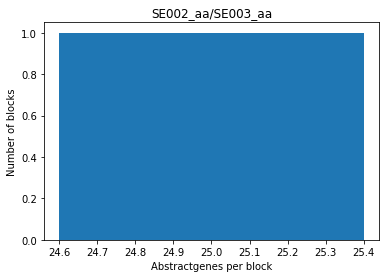

fin (<HOG(2)>, None)
fin (<HOG(3)>, <HOG(1)>)
fin (<HOG(4)>, <HOG(2)>)
fin (<HOG(3)>, <HOG(5)>)
fin (<HOG(6)>, <HOG(4)>)
fin (<HOG(7)>, <HOG(5)>)
fin (<HOG(8)>, <HOG(6)>)
fin (<HOG(9)>, <HOG(7)>)
fin (<HOG(8)>, <HOG(10)>)
fin (<HOG(11)>, <HOG(9)>)
fin (<HOG(14)>, <HOG(16)>)
fin (<HOG(15)>, <HOG(17)>)
fin (<HOG(16)>, <HOG(18)>)
fin (<HOG(17)>, <HOG(19)>)
fin (<HOG(18)>, <HOG(20)>)
fin (<HOG(19)>, <HOG(21)>)
fin (<HOG(20)>, <HOG(22)>)
fin (<HOG(21)>, <HOG(23)>)
fin (<HOG(24)>, <HOG(22)>)
fin (<HOG(25)>, <HOG(23)>)
fin (<HOG(24)>, None)
neighbors assigned
[[<HOG(11)>, <HOG(10)>, <HOG(9)>, <HOG(8)>, <HOG(7)>, <HOG(6)>, <HOG(5)>, <HOG(4)>, <HOG(3)>, <HOG(2)>, <HOG(1)>], [<HOG(13)>, <HOG(12)>], [<HOG(25)>, <HOG(24)>, <HOG(23)>, <HOG(22)>, <HOG(21)>, <HOG(20)>, <HOG(19)>, <HOG(18)>, <HOG(17)>, <HOG(16)>, <HOG(15)>, <HOG(14)>]]
next node


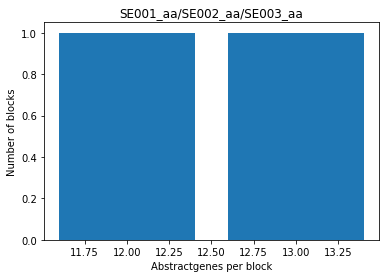

In [5]:
counter = 1
for node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    assign_neighbors(node.genome)
    print("neighbors assigned")
    get_synteny_blocks(node.genome)
    print("next node")
    assign_block_to_genes(node.genome)
    
    # here we go through all nodes, and if it is an ancestral, note, we make some plots
    # in my 3 species example, there are 2 ancestral nodes, so two plots
    
    if isinstance(node.genome, pyham.AncestralGenome):
        # links together the primary reconstruction's synteny blocks, using windows of 20
        joining_blocks(20, node.genome)
                
        ### Plot ###        
        title = node.genome.name  
        raw_values = []
        for block in node.genome.new_synteny:
            count = 0
            
            for element in block:
                # goes through the elements of that block, the HOGs         
                # if that element (HOG) is a pyham.HOG, increase count, it's the number of HOGs we've alignd the synteny of in this block
                if isinstance(element, pyham.HOG):
                    count += 1  
                    
            raw_values.append(count)
            
        label = list(set(raw_values))
        values = [0 for i in range(len(label))]
        
        for i in range(len(label)):
            for element in raw_values:                
                if label[i] == element:
                    values[i] += 1

        plt.bar(label, values)
        plt.title(title)
        plt.xlabel('Abstractgenes per block')
        plt.ylabel('Number of blocks')
        plt.savefig('results/secondary_reconstruction_plot{}.png'.format(counter))
        counter += 1
        plt.show()

## Graph Theory Approach

In [6]:
# make an empty graph with possibility of multiple edges per node
G = nx.MultiGraph()

In [7]:
G.number_of_nodes()

0

In [8]:
G.number_of_edges()

0

In [9]:
def make_synteny_graph(genome):
    
    """
    This function makes network graphs at the given level (genome) in the species tree.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        either a single graph for extant genes or multiple graphs for ancestral genes. 
        a graph for the HOGs and for each set of children from those HOGs at an ancestral node
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        # make the graphs
        all_graphs = []
        extant_gene_graph = nx.Graph()
        parent_gene_graph = nx.Graph()
        ##extant_gene_graph = nx.MultiGraph() # only if I needed multiple edges for the same pair of nodes
        
        extant_gene_graph.add_node("start")
        parent_gene_graph.add_node("start")

        old_node = "start"
        old_parent_node = "start"
        for extant_gene in genome.genes:            
            new_node = (get_gene_by_locus(genome, int(extant_gene.locus)))
            new_parent_node = new_node.parent
                ##print(new_node, new_parent_node)
                ##print("extant", new_node)        
            
            # add the nodes to a graph
            extant_gene_graph.add_node(new_node)
            parent_gene_graph.add_node(new_parent_node)
                ##print("node.number", extant_gene_graph.number_of_nodes())
                ##print("old", old_node)
                ##print("nodes", extant_gene_graph.nodes)

            # create edges between the correct nodes
            extant_gene_graph.add_edge(old_node, new_node)
            parent_gene_graph.add_edge(old_parent_node, new_parent_node)
                ##print("edge.number", extant_gene_graph.number_of_edges())
                ##print("edges", extant_gene_graph.edges)

            # save the old node to create the next edge
            old_node = new_node
            old_parent_node = new_parent_node
        
        extant_gene_graph.remove_node("start") # remove it, was only there to make the edges as we went along
        parent_gene_graph.remove_node("start") # remove it, was only there to make the edges as we went along
        
        all_graphs.append(extant_gene_graph)
        all_graphs.append(parent_gene_graph)
        
        return(all_graphs)

    
    if isinstance(genome, pyham.AncestralGenome):
        # at an ancestral node, we build the graph based on the graphs at the descendant node
        # so for now just make all the vertices in the graph, and in another function, compare to descendant to connect edges
        
        ancestral_gene_graph = nx.Graph()
        child1_gene_graph = nx.Graph()
        child2_gene_graph = nx.Graph()

        # make a list of lists
        #     - a parent graph
        #     - a graph for each set of children (maybe more than 2 children if polytomies?)
        all_graphs = []
#        hog_list = []
#        child1_list = []
#        child2_list = []        
        
        for ancestral_gene in genome.genes:
            ancestral_gene_graph.add_node(ancestral_gene)
            child1_gene_graph.add_node(ancestral_gene.children[0])
            child2_gene_graph.add_node(ancestral_gene.children[1])

#            hog_list.append(ancestral_gene)
#            child1_list.append(ancestral_gene.children[0])
#            child2_list.append(ancestral_gene.children[1])
            if len(ancestral_gene.children) > 2:
                print("fix problem, there is a polytomy")
            
        # make a graph from the list of nodes, complete graph makes edges between all nodes
#        ancestral_gene_graph = nx.complete_graph(hog_list)     
#        child1_gene_graph = nx.complete_graph(child1_list)     
#        child2_gene_graph = nx.complete_graph(child2_list)
        
        all_graphs.append(ancestral_gene_graph)
        all_graphs.append(child1_gene_graph)
        all_graphs.append(child2_gene_graph)
        
        return(all_graphs)

In [10]:
def compare_synteny_graphs(tree_node):
    
    """
    This function compares network graphs at the given level (genome) in the species tree to its descendant graphs.

    Args:
        genome (:obj:`pyham.genome.Genome`): ancestral genome of interest.

    Returns:
        either a single graph for extant genes or multiple graphs for ancestral genes. 
    """
    
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        print("synteny already assigned for extant genome")
        
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        print("ancestor", tree_node.graph[2].nodes)
        print("find synteny")
        
        # take this node ( go node by node)
        # get the descendant nodes
        # compare the synteny of the children graphs from this node to each descendant
        # use the children graphs to assign synteny to this hog graph

    #gene2 = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")
    #hog = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
    #print(hog.graph)
        #R.remove_nodes_from(n for n in G if n not in H)
        
# Then you get the corresponding mrca ancestral genomes 
#genome_rodents_3 = ham_analysis.get_ancestral_genome_by_mrca_of_genome_set({genome_rat, genome_mouse})
        



--SE001_aa

--SE002_aa

--SE003_aa

   /-SE002_aa
--|
   \-SE003_aa

   /-SE001_aa
--|
  |   /-SE002_aa
   \-|
      \-SE003_aa
synteny already assigned for extant genome
synteny already assigned for extant genome
synteny already assigned for extant genome
ancestor [Gene(51), Gene(52), Gene(53), Gene(54), Gene(55), Gene(56), Gene(57), Gene(58), Gene(59), Gene(60), Gene(61), Gene(63), Gene(62), Gene(64), Gene(65), Gene(66), Gene(67), Gene(68), Gene(69), Gene(70), Gene(71), Gene(72), Gene(73), Gene(74), Gene(75)]
find synteny
ancestor [<HOG(i1)>, <HOG(i2)>, <HOG(i3)>, <HOG(i4)>, <HOG(i5)>, <HOG(i6)>, <HOG(i7)>, <HOG(i8)>, <HOG(i9)>, <HOG(i10)>, <HOG(i11)>, <HOG(i12)>, <HOG(i13)>, <HOG(i14)>, <HOG(i15)>, <HOG(i16)>, <HOG(i17)>, <HOG(i18)>, <HOG(i19)>, <HOG(i20)>, <HOG(i21)>, <HOG(i22)>, <HOG(i23)>, <HOG(i24)>, <HOG(i25)>]
find synteny


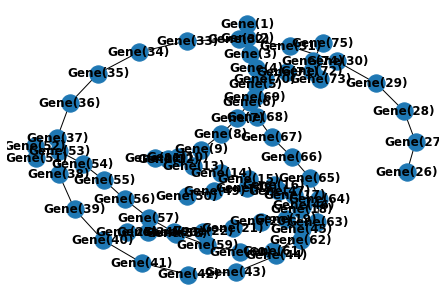

In [11]:
## Make initial graphs

for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    print(tree_node)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='bold')
        #nx.draw(tree_node.graph[1], with_labels=True, font_weight='bold')

    
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    compare_synteny_graphs(tree_node)
    
#    if isinstance(tree_node.genome, pyham.ExtantGenome): # then we already have the synteny and all is good
#        print(tree_node.graph.nodes)
#        print("nodes", tree_node.graph.number_of_nodes())
#        print("edges", tree_node.graph.number_of_edges())
        
#    if isinstance(tree_node.genome, pyham.AncestralGenome): # then we want to compare to assign the proper synteny
#        print("ancestor", tree_node.graph[0].nodes)
#        print("ancestor", tree_node.graph[1].nodes)
#        print("ancestor", tree_node.graph[2].nodes)
#        print("nodes", tree_node.graph[0].number_of_nodes())
#        print("edges", tree_node.graph[0].number_of_edges())

##print(ham_analysis_no_name.taxonomy.internal_nodes)
##print(ham_analysis_no_name.taxonomy.leaves)

In [13]:
# construct proper synteny at internal nodes

for tree_node in ham_analysis_no_name.taxonomy.internal_nodes: # NEED TO BE SURE IT AWAYS GOES IN POSTORDER?
    print(tree_node)
    print(tree_node.genome)
#ham_analysis_no_name.taxonomy.internal_nodes


   /-SE001_aa
--|
  |   /-SE002_aa
   \-|
      \-SE003_aa
SE001_aa/SE002_aa/SE003_aa

   /-SE002_aa
--|
   \-SE003_aa
SE002_aa/SE003_aa


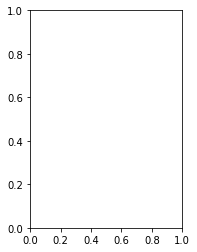

In [289]:
G = nx.petersen_graph()
plt.subplot(121)
#<matplotlib.axes._subplots.AxesSubplot object at ...>

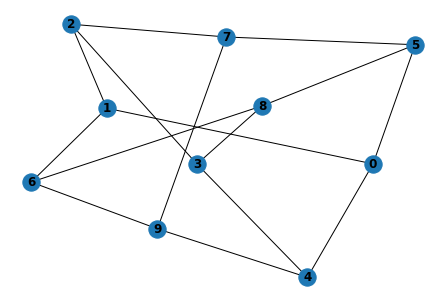

In [294]:
nx.draw(G, with_labels=True, font_weight='bold')
##plt.subplot(122)
#<matplotlib.axes._subplots.AxesSubplot object at ...>


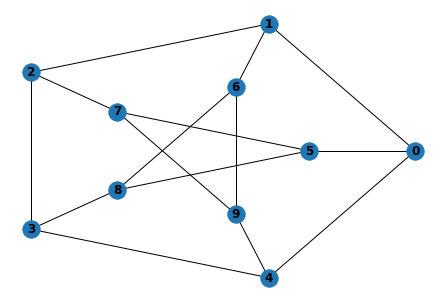

In [306]:
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')


In [26]:
test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
print(test.taxon.graph)
vars(test)

###nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')


[<networkx.classes.graph.Graph object at 0x11cd39c90>, <networkx.classes.graph.Graph object at 0x11cd39850>, <networkx.classes.graph.Graph object at 0x11cd39ad0>]


{'genes': [<HOG(i1)>,
  <HOG(i2)>,
  <HOG(i3)>,
  <HOG(i4)>,
  <HOG(i5)>,
  <HOG(i6)>,
  <HOG(i7)>,
  <HOG(i8)>,
  <HOG(i9)>,
  <HOG(i10)>,
  <HOG(i11)>,
  <HOG(i12)>,
  <HOG(i13)>,
  <HOG(i14)>,
  <HOG(i15)>,
  <HOG(i16)>,
  <HOG(i17)>,
  <HOG(i18)>,
  <HOG(i19)>,
  <HOG(i20)>,
  <HOG(i21)>,
  <HOG(i22)>,
  <HOG(i23)>,
  <HOG(i24)>,
  <HOG(i25)>],
 'taxon': Tree node 'SE002_aa/SE003_aa' (0x11c7399d),
 'name': 'SE002_aa/SE003_aa',
 'ancestral_clustering': None,
 'synteny': [[<HOG(i25)>,
   <HOG(i24)>,
   <HOG(i23)>,
   <HOG(i22)>,
   <HOG(i21)>,
   <HOG(i20)>,
   <HOG(i19)>,
   <HOG(i18)>,
   <HOG(i17)>,
   <HOG(i16)>,
   <HOG(i15)>,
   <HOG(i14)>,
   <HOG(i12)>,
   <HOG(i13)>,
   <HOG(i11)>,
   <HOG(i10)>,
   <HOG(i9)>,
   <HOG(i8)>,
   <HOG(i7)>,
   <HOG(i6)>,
   <HOG(i5)>,
   <HOG(i4)>,
   <HOG(i3)>,
   <HOG(i2)>,
   <HOG(i1)>]],
 'new_synteny': [[<HOG(i25)>,
   <HOG(i24)>,
   <HOG(i23)>,
   <HOG(i22)>,
   <HOG(i21)>,
   <HOG(i20)>,
   <HOG(i19)>,
   <HOG(i18)>,
   <HOG(i17)>,
   <H

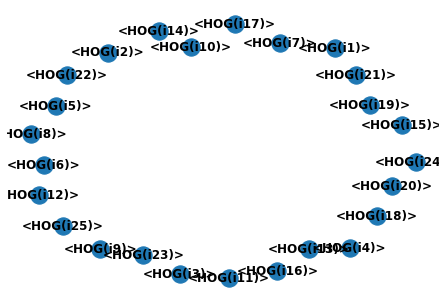

In [27]:
test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')


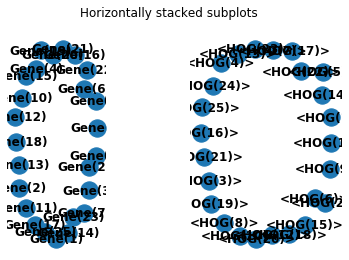

In [54]:
test = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE002_aa/SE003_aa")

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Horizontally stacked subplots')

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')
plt.subplot(131)

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw(test.taxon.graph[2], with_labels=True, font_weight='bold')
#plt.subplot(121)


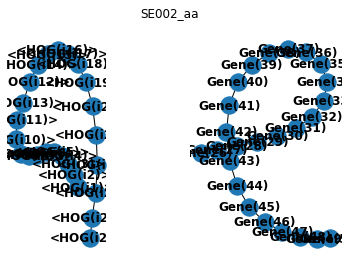

In [57]:
test = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('SE002_aa')

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')
plt.subplot(131)

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw(test.taxon.graph[2], with_labels=True, font_weight='bold')
#plt.subplot(121)